In [1]:
import os
import yaml
import numpy as np
from scipy.interpolate import CubicSpline
import jax
import jax.numpy as jnp
import mujoco
from mujoco import rollout
import concurrent.futures
import threading

In [2]:
import mujoco_viewer
import copy as cp
import matplotlib.pyplot as plt

In [3]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [4]:
model_sim = mujoco.MjModel.from_xml_path("../models/go1/go1_scene_jax_no_collision.xml")

In [5]:
model_sim.actuator('FR_hip').biasprm

array([  0., -50.,  -3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [6]:
model_sim.actuator('FL_calf').gainprm

array([50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [7]:
dt_sim = 0.01
model_sim.opt.timestep = dt_sim

data_sim = mujoco.MjData(model_sim)

In [8]:
viewer = mujoco_viewer.MujocoViewer(model_sim, data_sim, 'offscreen')

Configuration: [ 0.     0.     0.08   1.     0.     0.     0.     0.073  1.34  -2.83
  0.073  1.34  -2.83   0.073  1.34  -2.83   0.073  1.34  -2.83 ]


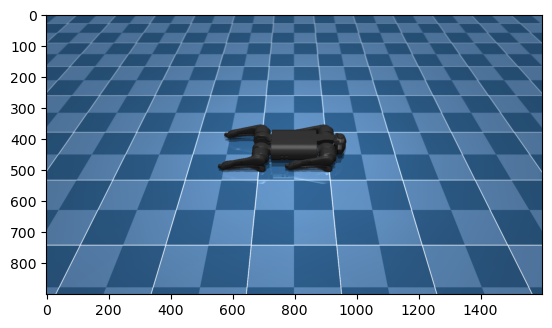

In [9]:
# reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 1) # stand position
mujoco.mj_forward(model_sim, data_sim)
q_init = cp.deepcopy(data_sim.qpos) # save reference pose
v_init = cp.deepcopy(data_sim.qvel) # save reference pose

print("Configuration: {}".format(q_init)) # save reference pose

img = viewer.read_pixels()
plt.imshow(img)

Configuration: [ 0.    0.    0.27  1.    0.    0.    0.    0.    0.9  -1.8   0.    0.9
 -1.8   0.    0.9  -1.8   0.    0.9  -1.8 ]


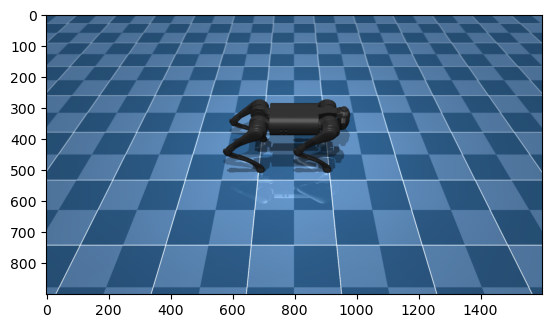

In [10]:
# reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 0) # stand position
mujoco.mj_forward(model_sim, data_sim)
q_ref_mj = cp.deepcopy(data_sim.qpos) # save reference pose
v_ref_mj = cp.deepcopy(data_sim.qvel) # save reference pose

print("Configuration: {}".format(q_ref_mj)) # save reference pose

img = viewer.read_pixels()
plt.imshow(img)

In [11]:
class GaitScheduler:
    def __init__(self, gait_path = '../gaits/waking_gait.tsv', dt = 0.1, phase_time = 0):
        # Load the configuration file
        with open(gait_path, 'r') as file:
            gait_array = np.loadtxt(file, delimiter='\t')
        
        # Load model
        self.gait = gait_array
        self.dt = dt
        self.phase_length = gait_array.shape[1]
        self.phase_time = phase_time
        self.indices = jnp.arange(self.phase_length)
        
    def roll(self):
        self.phase_time += 1
        self.indices = jnp.roll(self.indices, -1)
    
    def get_current_ref(self):
        return self.gait[:, self.phase_time]

In [12]:
class MPPI:
    def __init__(self, model_path, config_path):
        # Load the configuration file
        with open(config_path, 'r') as file:
            params = yaml.safe_load(file)
    
        # Load model
        self.model = mujoco.MjModel.from_xml_path(model_path)
        self.model.opt.timestep = params['dt']

        # MPPI controller configuration
        self.temperature = params['lambda']
        self.horizon = params['horizon']
        self.n_samples = params['n_samples']
        self.noise_sigma = jnp.array(params['noise_sigma'])
        self.num_workers = params['n_workers']
        self.sampling_init = jnp.array([0.073,  1.34, -2.83,  
                                        0.073,  1.34, -2.83,  
                                        0.073,  1.34, -2.83,  
                                        0.073,  1.34, -2.83])
        
        # Cost
        self.Q = jnp.diag(jnp.array(params['Q_diag']))
        self.R = jnp.diag(jnp.array(params['R_diag']))
        self.x_ref = jnp.concatenate([jnp.array(params['q_ref']), jnp.array(params['v_ref'])])
        self.q_ref = jnp.array(params['q_ref'])
        self.v_ref = jnp.array(params['v_ref'])
        self.body_ref = jnp.concatenate([self.q_ref[:7], self.v_ref[:6]])
        
        # Threding
        self.thread_local = threading.local()

        # Get env parameters
        self.act_dim = 12
        self.act_max = [0.863, 4.501, -0.888]*4
        self.act_min = [-0.863, -0.686, -2.818]*4
        
        # Gait scheduler
        self.gait_scheduler = GaitScheduler()
        #self.x_ref = jnp.concatenate([jnp.array(params['q_ref']), jnp.array(params['v_ref'])])
        
        # Rollouts
        self.h = params['dt']
        self.sample_type = params['sample_type']
        self.n_knots = params['n_knots']
        self.random_generator = np.random.default_rng(params["seed"])
        
        self.rollout_func = self.threaded_rollout
        self.cost_func = jax.jit(jax.vmap(jax.vmap(self.quadruped_cost, in_axes=(0, 0, None, None, None, None, None)), in_axes=(1, 1, 0, None, None, None, None))) #, device=gpu_device)
        self.state_rollouts = np.zeros((self.n_samples, self.horizon, mujoco.mj_stateSize(self.model, mujoco.mjtState.mjSTATE_FULLPHYSICS.value)))
            
        self.trajectory = None
        self.reset_planner() 
        self.update(self.x_ref)
        self.reset_planner()     
                
    def reset_planner(self):
        self.trajectory = np.zeros((self.horizon, self.act_dim))
        self.trajectory += self.sampling_init
            
    def generate_noise(self, size):
        return self.random_generator.normal(size=size) * self.noise_sigma
    
    def sample_delta_u(self):
        if self.sample_type == 'normal':
            size = (self.n_samples, self.horizon, self.act_dim)
            return self.generate_noise(size)
        elif self.sample_type == 'cubic':
            indices = np.arange(self.n_knots)*self.horizon//self.n_knots
            size = (self.n_samples, self.n_knots, self.act_dim)
            knot_points = self.generate_noise(size)
            cubic_spline = CubicSpline(indices, knot_points, axis=1)
            return cubic_spline(np.arange(self.horizon))
        
    def perturb_action(self):
        if self.sample_type == 'normal':
            size = (self.n_samples, self.horizon, self.act_dim)
            actions = self.trajectory + self.generate_noise(size)
            actions = np.clip(actions, self.act_min, self.act_max)
            return actions
        
        elif self.sample_type == 'cubic':
            indices_float = jnp.linspace(0, self.horizon - 1, num=self.n_knots)
            indices = jnp.round(indices_float).astype(int)
            size = (self.n_samples, self.n_knots, self.act_dim)
            knot_points = self.trajectory[indices] + self.generate_noise(size)
            cubic_spline = CubicSpline(indices, knot_points, axis=1)
            actions = cubic_spline(np.arange(self.horizon))
            actions = np.clip(actions, self.act_min, self.act_max)
            return actions
        
    def update(self, obs): 
        actions = self.perturb_action()
        self.rollout_func(self.state_rollouts, actions, np.repeat([np.concatenate([[0],obs])], self.n_samples, axis=0), num_workers=self.num_workers, nstep=self.horizon)
        costs = self.cost_func(self.state_rollouts[:,:,1:], actions, 
                               self.gait_scheduler.indices[:self.horizon],
                               self.Q, self.R, self.gait_scheduler.gait, self.body_ref)
        #costs = self.cost_func(self.state_rollouts[:,:,1:], actions)
        
        self.gait_scheduler.roll()
        costs_sum = costs.sum(axis=0)
        
        # MPPI weights calculation
        ## Scale parameters
        min_cost = np.min(costs_sum)
        max_cost = np.max(costs_sum)
        
        exp_weights = np.exp(-1/self.temperature * ((costs_sum - min_cost)/(max_cost - min_cost)))
        weighted_delta_u = exp_weights.reshape(self.n_samples, 1, 1) * actions
        weighted_delta_u = np.sum(weighted_delta_u, axis=0) / (np.sum(exp_weights) + 1e-10)
        updated_actions = np.clip(weighted_delta_u, self.act_min, self.act_max)
    
        # Pop out first action from the trajectory and repeat last action
        self.trajectory = np.roll(updated_actions, shift=-1, axis=0)
        self.trajectory[-1] = updated_actions[-1]

        # Output first action (MPC)
        action = updated_actions[0] 
        return action
    
    def thread_initializer(self):
        self.thread_local.data = mujoco.MjData(self.model)

    def call_rollout(self, initial_state, ctrl, state):
        rollout.rollout(self.model, self.thread_local.data, skip_checks=True,
                        nroll=state.shape[0], nstep=state.shape[1],
                        initial_state=initial_state, control=ctrl, state=state)

    def threaded_rollout(self, state, ctrl, initial_state, num_workers=32, nstep=5):
        n = initial_state.shape[0] // num_workers  # integer division

        chunks = []  # a list of tuples, one per worker
        for i in range(num_workers-1):
            chunks.append(
                (initial_state[i*n:(i+1)*n], ctrl[i*n:(i+1)*n], state[i*n:(i+1)*n]))

        # Last chunk, absorbing the remainder:
        chunks.append(
            (initial_state[(num_workers-1)*n:], ctrl[(num_workers-1)*n:],
                state[(num_workers-1)*n:]))

        with concurrent.futures.ThreadPoolExecutor(
            max_workers=num_workers, initializer=self.thread_initializer) as executor:
            futures = []
            for chunk in chunks:
                futures.append(executor.submit(self.call_rollout, *chunk))
            for future in concurrent.futures.as_completed(futures):
                future.result()
    
    def quaternion_distance(self, q1, q2):
        return 1 - jnp.abs(jnp.dot(q1,q2))
    
    def quadruped_cost(self, x, u, phase_time, Q, R, joints_gait, body_ref):
        kp = 30
        kd = 3

        joints_ref = joints_gait[:, phase_time]
        x_ref = jnp.concatenate([body_ref[:7], joints_ref[:12], body_ref[7:], joints_ref[12:]])

        # Compute the error terms
        x_error = x - x_ref

        # Assuming quaternion_distance is a function you've defined elsewhere
        x_error = x_error.at[3:7].set(self.quaternion_distance(x[3:7], x_ref[3:7]))
        u_error = kp*(u - x[7:19]) #+ kd*(x_ref[25:] - x[25:])

        # Compute the cost
        cost = jnp.dot(x_error, jnp.dot(Q, x_error)) + jnp.dot(u_error, jnp.dot(R, u_error))
        return cost

In [13]:
model_path = "../models/go1/go1_scene_jax_no_collision.xml"
config_path = "configs/mppi.yml"
mppi = MPPI(model_path, config_path)
mppi.reset_planner()

In [14]:
q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
x = jnp.concatenate([q_curr, v_curr])

In [15]:
tfinal = 5
tvec = jnp.linspace(0,tfinal,int(jnp.ceil(tfinal/dt_sim))+1)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 0)
mujoco.mj_forward(model_sim, data_sim)

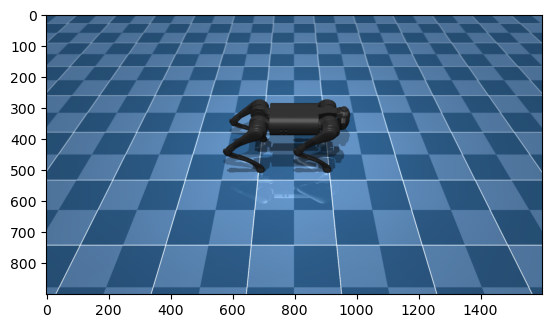

In [16]:
img = viewer.read_pixels()
plt.imshow(img)

In [17]:
%%time
anim_imgs = []
sim_inputs = []
for ticks, ti in enumerate(tvec):
    q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
    v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
    x = jnp.concatenate([q_curr, v_curr])
    u_joints = mppi.update(x)    
    data_sim.ctrl[:] = u_joints
    mujoco.mj_step(model_sim, data_sim)
    mujoco.mj_forward(model_sim, data_sim)
    img = viewer.read_pixels()
    anim_imgs.append(img)
    sim_inputs.append(u_joints)

CPU times: user 12.7 s, sys: 837 ms, total: 13.5 s
Wall time: 5.92 s


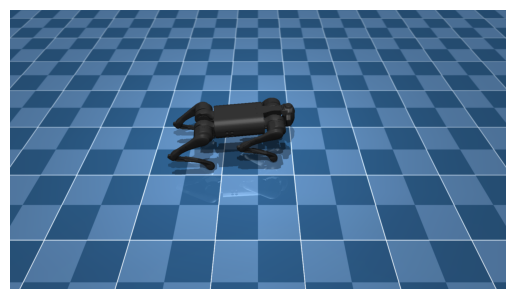

In [18]:
fig, ax = plt.subplots()
skip_frames = 10
interval = dt_sim*1000*skip_frames

def animate(i):
    ax.clear()
    ax.imshow(anim_imgs[i * skip_frames])  # Display the image, skipping frames
    ax.axis('off')

# Create animation, considering the reduced frame rate due to skipped frames
ani = FuncAnimation(fig, animate, frames=len(anim_imgs) // skip_frames, interval=interval)  # 50 ms for 20 Hz

# Display the animation
HTML(ani.to_jshtml())